# Spam Classification

The objective of it is to generate a model capable to classify a email as spam or not spam.

The dataset used was from http://www2.aueb.gr/users/ion/data/enron-spam/

#### Imports

In [1]:
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text as txt
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import email
from email.message import EmailMessage
from email.parser import BytesParser, Parser
from email.policy import default
import ast
import re
import datetime
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /home/phrc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/phrc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Functions

In [79]:
def createDf(path):
    """
    Read all email files and convert to a dataframe

    Parameters
    ----------
    path: str
        Path to a root directory to be read

    Returns
    ----------
    dataframe
        a dataframe with x columns based in all emails properties
    """
    os.chdir(path)
    data = []
    for root, dirs, files in os.walk(path):
         for file in files:
            with open(os.path.join(root, file), "rb") as openFile:
                dictTemp = {}
                try:
                    message = email.message_from_binary_file(openFile, policy=default)
                    #Parser(policy=default).parsestr(openFile.read())
                    dictTemp['file'] = openFile.name
                    for key in message.keys():
                        dictTemp[key.lower()] = message[key]
                    dictTemp['messageType'] = message.get_content_type()
                    body = message.get_body()
                    if body['content-type'].maintype == 'text':
                        if body['content-type'].subtype == 'plain':
                            dictTemp['messageStr'] = str(body.get_content())
                        elif body['content-type'].subtype == 'html':
                            dictTemp['messageStr'] = str(body)
                    elif body['content-type'].content_type in 'multipart':
                        dictTemp['messageStr'] = str(body.get_body(preferencelist=('html')))
                    dictTemp['parseError'] = False                 
                except:
                    dictTemp['parseError'] = True
                data.append(dictTemp)
    df = pd.DataFrame(data)
    return df

def emailTextCleanner(text):
    """
    Remove:
        Html Tags
        Email headers
        Ponctuation
        break lines and tabs
    
    And convert the string to lower case 

    Parameters
    ----------
    text: str

    Returns
    ----------
    str
    """
    try:
        text = str(text).lower()
        text = text.replace("\\", " ")
        text = text.replace("\x01", " ")
        clean = re.compile('charset.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('content-.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('received: from.*\n')
        text = re.sub(clean, '', text)
        text = text.replace('\n', ' ')
        text = text.replace('\t', ' ')
        clean = re.compile('<.*?>')
        text = re.sub(clean, '', str(text))
        clean = re.compile('['+string.punctuation+']')
        text = re.sub(clean, ' ', text)
        clean = re.compile("[0-9]")
        text = re.sub(clean, " ", text)
        toRemove = frozenset(['xpriority','nbsp', 'enron','xmsmailpriority','xmimeole','mimeole','cc','enrons', 'fw', 're'])
        pattern = re.compile(r'\b(' + r'|'.join(toRemove) + r')\b\s*')
        text = pattern.sub(' ', text)
 
        return text
    except:
        print(type(text))
        return ""
    #text = TextBlob(text)
    #text = str(text.correct())
    
def lemmatizeList(words):
    """
    Lemmatize a list of string

    Parameters
    ----------
    words: list of str

    Returns
    ----------
    list of str
    """
    lem = WordNetLemmatizer()
    for i in range(len(words)):
        words[i] = lem.lemmatize(words[i], 'v')
        words[i] = lem.lemmatize(words[i], 'n')
    return words

def revomeWordsWithOneCharacter(words):
    return list(filter(lambda x : len(x) > 1, words))

def removeDigits(words):
    return list(filter(lambda x : x.isdigit() == False, words))

def createPlotLenghtDist(col, df):
    fig = plt.figure(figsize = (18,6))
    grid = plt.GridSpec(1,4, wspace =0.8)
    histPlt = fig.add_subplot(grid[0,0:2])
    boxPlt1 = fig.add_subplot(grid[0,2])
    boxPlt2 = fig.add_subplot(grid[0,3])

    histPlt.hist(
        [
            df[df['isSpam'] == True][col], 
            df[df['isSpam'] == False][col]
        ], 
        np.linspace(0, df[col].quantile(0.75), 30), 
        density = True, 
        label=['Spam', 'Ham']
    ) 
    histPlt.legend(loc='upper right')

    boxPlt1.boxplot(
        (
             df[df['isSpam'] == True][col], 
             df[df['isSpam'] == False][col] 
        ), 
        labels = ('Spam', 'Ham')
    )

    boxPlt2.boxplot(
        (
            df[(df['isSpam'] == True) & (df[col] < df[col].quantile(0.75))][col], 
            df[(df['isSpam'] == False) & (df[col] < df[col].quantile(0.75))][col] 
        ), 
        labels = ('Spam', 'Ham')
    )

    plt.show()

def plot20MostWord(counter):
    df = pd.DataFrame(list(dict(counter).items()))
    df.columns = ['word', 'occur'] 
    totalOcurr = df['occur'].sum()
    df['freq'] = df['occur'] / totalOcurr  
    df = df.sort_values(by='freq', ascending=False)
    df = df.reset_index(drop=True)
    df['freqAcum'] = df['freq'].cumsum()


    fig = plt.figure(figsize = (18,12))
    grid = plt.GridSpec(4,2, wspace =0.2, hspace = 0.5)
    pltLine = fig.add_subplot(grid[0:2,0])
    pltBar = fig.add_subplot(grid[2:4,0:2])
    pltTable = fig.add_subplot(grid[0:2,1])

    pltLine.plot(df['freqAcum'], range(len(df)))
    pltLine.set_ylabel('Number of Words')
    pltLine.set_xlabel('Acumulative Frequence')
    pltLine.set_title('Line Graph of acumulative frequence')
    pltLine.grid(True)


    dfTWord = df.loc[[0,20,50,100,500,1000,5000,10000,15000]][['freqAcum']]

    pltTable.table(cellText=dfTWord.values, rowLabels= dfTWord.index, colLabels = dfTWord.columns, loc='best')
    pltTable.axis('off')
    pltTable.set_title('Table of acumulative frequence')



    pltBar.bar(df.head(20)['word'], df.head(20)['freq'])
    pltBar.set_title('20 Most Used word')

    yPos = np.arange(20)
    pltBar.set_xticklabels(df.head(20)["word"], rotation=60)
    pltBar.set_xticks(yPos)


    plt.show()
    
def totalUniqueWordsPlot(l1,l2,l3):
    fig = plt.figure(figsize = (18,6))
    grid = plt.GridSpec(1,2, wspace =0.2)
    pltBar = fig.add_subplot(grid[0,0])
    pltText = fig.add_subplot(grid[0,1])

    pltBar.bar(
        ['Total unique words', 'Spam unique words', 'Ham unique words'], 
        [l1,l2,l3], 
        align='center'
    )

    textWords = ['Total unique words:              {}'.format(l1), 
                 'Total spam unique words:    {}'.format(l2), 
                 'Total ham unique words:      {}'.format(l3)]



    pltText.text(x=0, y=0.5, s = '\n'.join(textWords), fontsize = 18) 
    pltText.axis('off')
    plt.show()

def getEmailRoot(email):
    try:
        email1 = email.replace(".", " ")
        emailVet = email1.split()
        matching = [s for s in emailVet if "@" in s] 
        return matching[0].replace("<", "").replace(">", "")
    except:
        return "None" 

def getEmailPartRoot(root, i):
    try:
        return root.split("@")[i]
    except:
        return "None"

def train_model(classifier, feature_vector_train, label, feature_vector_valid, ytest):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_valid)
    return metrics.accuracy_score(predictions, ytest)

## Dataset generation

In [80]:
root = '/home/phrc/Python Project/Spam Email Classifier/'
#root = '/Users/phrc/Documents/Projects/pythonProject/SpamEmailClassifier/'

spamPath = root+'emails/spam/'
hamPath = root+'emails/ham/'


dfSpam = createDf(spamPath)
dfHam = createDf(hamPath)

# Dataset Visualisation and Preparation 

## Dataset Size

Total emails 52076


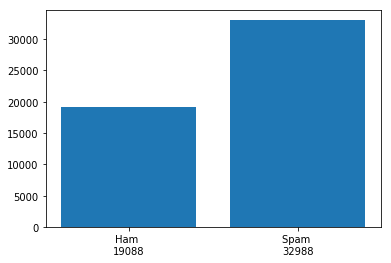

In [81]:
print("Total emails {}".format(len(dfHam) + len(dfSpam)))

plt.bar(np.arange(2), (len(dfHam), len(dfSpam)), align='center')
plt.xticks(np.arange(2), ('Ham \n{}'.format(len(dfHam)), 'Spam \n{}'.format(len(dfSpam))))

plt.show();

## Dataset Spam Columns Analyse

In [82]:
dfSpamDesc = dfSpam.describe(include=['object']).T
print('Total of Spam attributes {}'.format(len(dfSpamDesc)))
n = len(dfSpam) * 0.75 
dfSpamDesc[dfSpamDesc['count'] > n].head(300)

Total of Spam attributes 465


,count,unique,top,freq
content-type,32835,7616,"text/html; charset=""iso-8859-7""",12553
date,32572,30490,"Tue, 19 Jan 2038 11:14:07 +0800",52
file,32988,32988,/home/phrc/Python Project/Spam Email Classifie...,1
from,32957,27895,COMPUTRON <khatun@emirates.net.ae>,347
messageStr,29849,27602,Call out Gouranga be happy!!!\nGouranga Gouran...,79
messageType,32965,8,text/html,16715
mime-version,31915,448,1.0,30943
subject,32831,20625,,613
to,32380,5254,paliourg@iit.demokritos.gr,7068


## Dataset Ham Columns Analyse

In [83]:
dfHamDesc = dfHam.describe(include=['object']).T
print('Total of Ham attributes {}'.format(len(dfHamDesc)))
n = len(dfHam) * 0.75 
dfHamDesc[dfHamDesc['count']> n].head(300)

Total of Ham attributes 19


,count,unique,top,freq
content-transfer-encoding,19079,2,7bit,18363
content-type,19079,2,"text/plain; charset=""us-ascii""",17818
date,19088,18173,"Tue, 21 Aug 2001 14:57:01 -0700",5
file,19088,19088,/home/phrc/Python Project/Spam Email Classifie...,1
from,19088,2349,pete.davis@enron.com,1395
message-id,19088,19088,<14056189.1075840825996.JavaMail.evans@thyme>,1
messageStr,19079,18401,\n\nTammie Schoppe\nEnron Americas-Office of ...,5
messageType,19079,1,text/plain,19079
mime-version,19079,1,1.0,19079
subject,19084,14679,Schedule Crawler: HourAhead Failure,343


## Parser Emails Error Analyse 

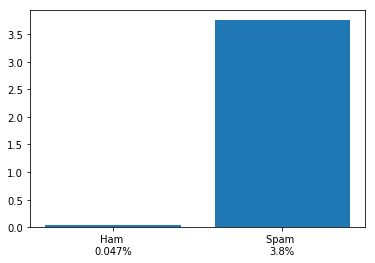

In [84]:
dfHamP = dfHam[dfHam['parseError'] == True]
dfSpamP = dfSpam[dfSpam['parseError'] == True]
hamFreq = (len(dfHamP) * 100 / len(dfHam))
spamFreq = (len(dfSpamP) * 100 / len(dfSpam))
plt.bar(np.arange(2), (hamFreq, spamFreq), align='center')
plt.xticks(np.arange(2), ('Ham \n{0:.2}%'.format(hamFreq), 'Spam \n{0:.2}%'.format(spamFreq)))

plt.show();

### -- Removing emails with parser problems 

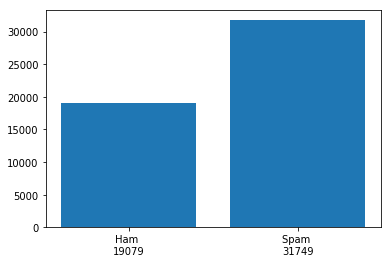

In [85]:
dfSpam = dfSpam[dfSpam['parseError'] == False]
dfHam = dfHam[dfHam['parseError'] == False]

plt.bar(np.arange(2), (len(dfHam), len(dfSpam)), align='center')
plt.xticks(np.arange(2), ('Ham \n{}'.format(len(dfHam)), 'Spam \n{}'.format(len(dfSpam))))

plt.show();

## Join Dataset and Remove unnescessary columns

In [86]:
dfSpam = dfSpam[['date', 'from', 'messageStr', 'messageType', 'subject', 'to']]
dfHam = dfHam[['date', 'from', 'messageStr', 'messageType', 'subject', 'to']]

dfSpam['isSpam'] = True
dfHam['isSpam'] = False

dfMaster = pd.concat([dfSpam, dfHam])
print('Total size of dataset {}'.format(len(dfMaster)))
dfMaster.head()

Total size of dataset 50828


,date,from,messageStr,messageType,subject,to,isSpam
0,"Fri, 24 Jun 2005 23:29:50 +0600",Semen Analysis <ezcnppih@rogers.com>,"""My girlfriend and me have been really enjoyin...",text/plain,squirts like a fountain,projecthoneypot@projecthoneypot.org,True
1,"Fri, 24 Jun 2005 06:36:39 -0500",GoTo My Meeting <meeting@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,True
3,"Wed, 13 Jul 2005 09:06:59 -0400",Donovan Wilson <KHTIQA@yahoo.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,True
4,"Sun, 03 Jul 2005 21:45:26 +0000",Olene Nash <assisneto2003@nteu35.org>,Received: from unknown (HELO @matrixmailserver...,text/html,Save your money buy getting this thing here,projecthoneypot@projecthoneypot.org,True
5,"Wed, 22 Jun 2005 05:57:20 -0500",Barclays Bank PLC <account@Barclays.co.uk>,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,True


## Check for Empty e-mail messages 

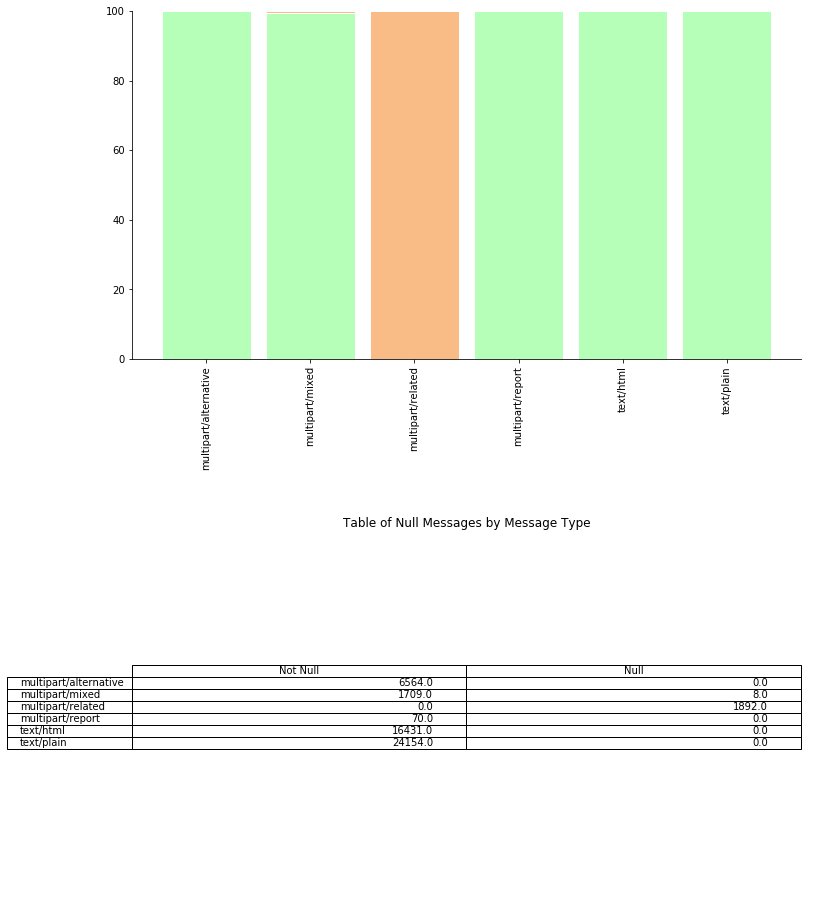

In [87]:
fig = plt.figure(figsize = (12,16))
grid = plt.GridSpec(2,3, wspace =0.3, hspace =0.5)
stackBar = fig.add_subplot(grid[0,0:3])
tableMsg = fig.add_subplot(grid[1,0:3])

dfMaster['msgIsNull'] = dfMaster['messageStr'].isnull()
dfGroup2 = dfMaster.groupby(['messageType', 'msgIsNull']).size()

dfG2 = dfGroup2.unstack()
dfG2 = dfG2.fillna(0)

dfMaster['msgIsNull'] = dfMaster['messageStr'].isnull()
dfGroup2 = dfMaster.groupby(['messageType', 'msgIsNull']).size()

dfG2 = dfGroup2.unstack().fillna(0)

totals = [i+j for i,j in zip(dfG2[False], dfG2[True])]
falseBars = [i / j * 100 for i,j in zip(dfG2[False], totals)]
trueBars = [i / j * 100 for i,j in zip(dfG2[True], totals)]

stackBar.bar(range(len(dfG2)), falseBars, color='#b5ffb9', edgecolor='white', width=0.85)
stackBar.bar(range(len(dfG2)), trueBars, bottom=falseBars, color='#f9bc86', edgecolor='white', width=0.85)

stackBar.set_xticks(range(len(dfG2)))
stackBar.set_xticklabels(dfG2.index.values, rotation='vertical')
stackBar.spines['top'].set_visible(False)
stackBar.spines['right'].set_visible(False)
stackBar.get_xaxis().tick_bottom()
stackBar.get_yaxis().tick_left()

tableMsg.table(cellText=dfG2.values, rowLabels= dfG2.index, colLabels = ['Not Null', 'Null'], loc='center')
tableMsg.axis('off')
tableMsg.set_title('Table of Null Messages by Message Type')

plt.show()

del dfMaster['msgIsNull']

## Remove Empty e-mail messages 

In [88]:
dfMaster = dfMaster[dfMaster['messageStr'].notnull()]

print('Total size of dataset: {}'.format(len(dfMaster[dfMaster['messageStr'].notnull()])))

Total size of dataset: 48928


## Conclusion




There was a problem with encoding file format and the content type of the email during the email reading process and because of it, 3148 from 52076 (or 6.05%) email was losted.
From all 3148 email losted only 9 email was ham.

The treament to fix the problem wasn't made beacuse of some external factors and the amount of email losted.

But for future work a enconding type check before read the email file and a proper commands to read email multipart/releated content type will fix the error and improve the parsing.

## Dataset distribution by spam type

## -- Size

Spam    29849
Ham     19079
Name: isSpam, dtype: int64


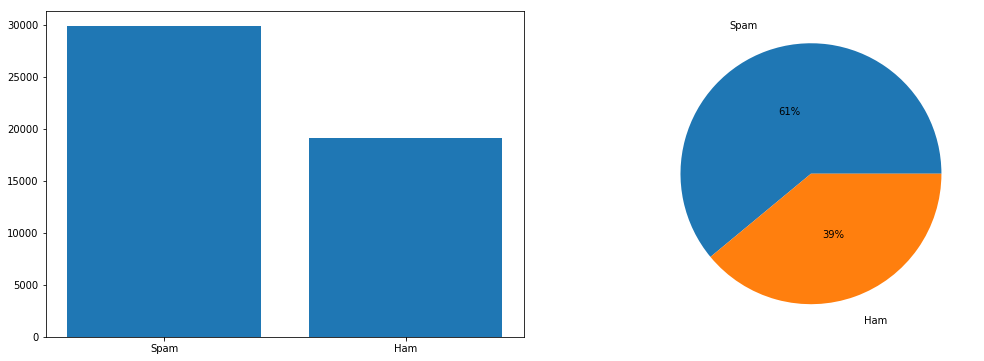

In [92]:
print(dfMaster['isSpam'].value_counts().rename({False: 'Ham', True: 'Spam'}))


fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,2, wspace =0.1)
barPlt = fig.add_subplot(grid[0,0])
piePlt = fig.add_subplot(grid[0,1])


barPlt.bar(
    ('Spam', 'Ham'), 
    [len(dfMaster[dfMaster['isSpam'] == True]), len(dfMaster[dfMaster['isSpam'] == False])], 
    align='center')
barPlt.set_xticks(np.arange(2), ['Spam', 'Ham'])


piePlt.pie(dfMaster['isSpam'].value_counts(), labels=['Spam', 'Ham'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


plt.show()

#### conclusion

The objective of this project it's create a algorithm capable to classify if a email is a spam and having a evenly proportion of email can helps in the training and reduce the changes of miss classification.

The ham and spam email doesn't have a perfect even proportion (61 by 39), the difference between them represent 22% from the total of emails. 

The differences seems to be moderate to low and for this case it is being assumed won't cause a significant difference in the model.

This project will use differents types of models and one of those types will considere the relative frequence what will solve this problem and the comparison between models can explain if this distribution is causing effect or not.

## -- Message Type

messageType            isSpam
multipart/alternative  True       6564
multipart/mixed        True       1709
multipart/report       True         70
text/html              True      16431
text/plain             False     19079
                       True       5075
dtype: int64


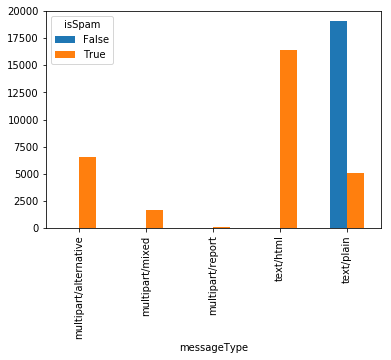

In [94]:
dfGroup = dfMaster.groupby(['messageType', 'isSpam']).size()
print(dfGroup)
dfGroup.unstack().plot(kind='bar', legend=True)


isPlain  isSpam
False    True      24774
True     False     19079
         True       5075
dtype: int64


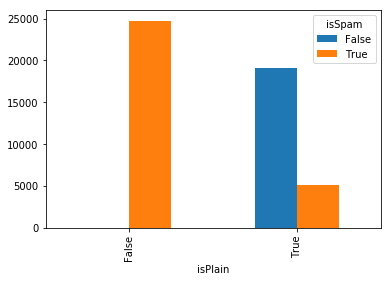

In [95]:
dfMaster['isPlain'] = dfMaster['messageType'].apply(lambda x : True if x == 'text/plain' else False)

dfGroup = dfMaster.groupby(['isPlain', 'isSpam']).size()
print(dfGroup)
dfGroup.unstack().plot(kind='bar', legend=True)

#### Conclusion

The email content can contain html elements, images, attachemnts, plain text or a mix of everthing and it is classify in content types, like text/plain, text/html, multipart/alternative... 

The comparison between the content type and spam result in all ham email is text/plain but not all text plain is ham and because of this deduction, all the types was divided between is text plain or not.

This treatement has the objective to simplfy the model.


## -- Day Hour

In [96]:
#Convert Date to a date time object
dfMaster['date'] = dfMaster['date'].apply(lambda x : str(x)).apply(lambda x : None if x == 'nan' else datetime.datetime.strptime(x, '%a, %d %b %Y %H:%M:%S %z'))
#Create a Hour Column
dfMaster['hour'] = dfMaster['date'].apply(lambda x : None if x == None else x.hour)

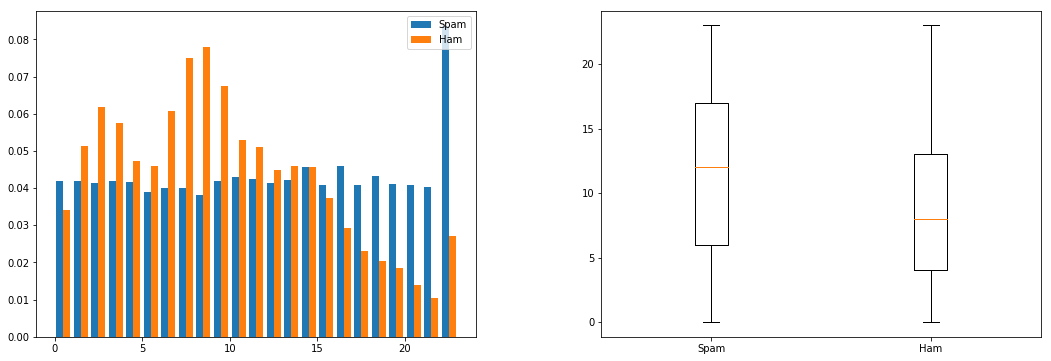

In [97]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2:4])

histPlt.hist(
    [
        dfMaster[dfMaster['isSpam'] == True]['hour'].dropna(), 
        dfMaster[dfMaster['isSpam'] == False]['hour']
    ], 
    np.linspace(0, dfMaster['hour'].max(), 24), 
    density = True, 
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        dfMaster[dfMaster['isSpam'] == True]['hour'].dropna(),
        dfMaster[dfMaster['isSpam'] == False]['hour']
    ), 
    labels = ('Spam', 'Ham')
)


plt.show()

#### Conclusion

The objective of this analyse is to find a relation between the period of the day and the email type and because of that, the time zone was disconsidereing during the cleaning, because the ideia is to know the exatcly hour the user receives the email.


The ham email is more frequently sent during the first hours of the morning and has the day pass, the amount of email sent decrease, having another small pick around of 3 am.

The spam email seems to have the same proportion during all day except at midnight when it shows a huge pick.

## -- How many person this email was send TO 

In [98]:
#Create a count to
dfMaster['toCount'] = dfMaster['to'].str.split(',').apply(lambda x : len(x) if isinstance(x, list) else 0)

### --- Description for send to

In [99]:
dfMaster['toCount'].describe()

count    48928.000000
mean         3.165284
std         13.404586
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        595.000000
Name: toCount, dtype: float64

### --- Description for send to for more than one

In [100]:
dfMaster[dfMaster['toCount'] > 1]['toCount'].describe()

count    8038.000000
mean       14.333167
std        30.731960
min         2.000000
25%         3.000000
50%         6.000000
75%        12.000000
max       595.000000
Name: toCount, dtype: float64

### --- Proportion direct email and group email

1       39661
2-15     7678
15+      1589
Name: toCountG2, dtype: int64


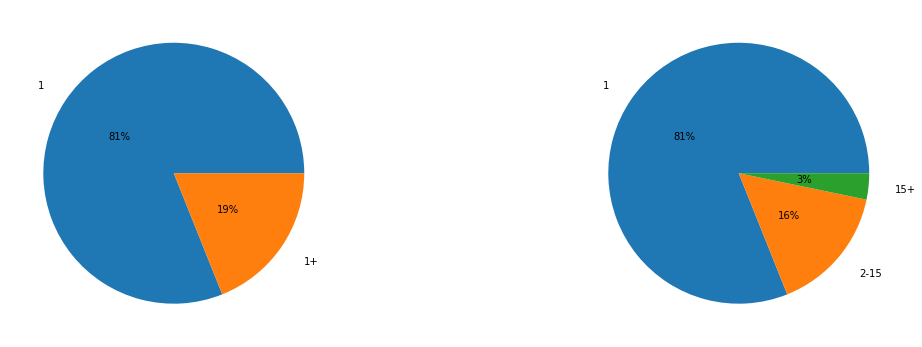

In [101]:
dfTemp = dfMaster.loc[:, ['toCount', 'isSpam']]
dfTemp['toCountG1'] = dfTemp['toCount'].apply(lambda x : '1' if x == 1 else '1+')
dfTemp['toCountG2'] = dfTemp['toCount'].apply(lambda x : '1' if x == 1 else ('15+' if x > 15 else '2-15'))

print(dfTemp['toCountG2'].value_counts())

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
pie1 = fig.add_subplot(grid[0,0:2])
pie2 = fig.add_subplot(grid[0,2:4])

pie1.pie(dfTemp['toCountG1'].value_counts(), labels=['1', '1+'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)

pie2.pie(dfTemp['toCountG2'].value_counts(), labels=['1', '2-15', '15+'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


plt.show()

### --- Distribution of 'To Group' by Spam

In [102]:
dfMaster['toCountGroup'] = dfMaster['toCount'].apply(lambda x: 'Direct' if x == 1 else ('Small Group' if x < 15 else 'Big Group')) 

In [103]:
dfGroupTo = dfMaster.groupby(['toCountGroup', 'isSpam']).size()
print(dfGroupTo.unstack().columns.values)
dfGT = dfGroupTo.unstack()
dfGT['rateF'] = dfGT[False] / (dfGT[False] + dfGT[True])
dfGT['rateT'] = dfGT[True] / (dfGT[False] + dfGT[True])

dfGT.columns = ['Not Spam', 'Spam', 'Rate Not Spam', 'Rate Spam']

dfGT.head()

[False True]


,Not Spam,Spam,Rate Not Spam,Rate Spam
toCountGroup,,,,
Big Group,1632,63,0.962832,0.037168
Direct,11703,27958,0.295076,0.704924
Small Group,5744,1828,0.758584,0.241416


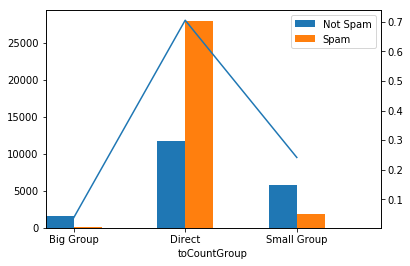

In [104]:
width = .25

dfGT[['Not Spam', 'Spam']].plot(kind='bar')
dfGT['Rate Spam'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-width, len(dfGT)-width])
ax.set_xticklabels(dfGT.index.values)
ax.set_xlabel('Groups')
plt.show()

#.plot(kind='bar', legend=False)

#### Conclusion

A email can be sent to one or more people, the reason of this analyse is to find a relation betweent it and the type of email. 

This variable, already starts with a issue, becasue there is two ways to include a person in a email, it can be occult or normal, in case of it being occult, this information will be missing.

In the first stage was found 81% of the email from our dataset was send to one person 16% to 2 to 15 people and 3 % for more than 15 people

It was expected spam emails to be sent to more than one person, but in this analyse was sent direct to one person, and this maybe can be explian by the copy occulty or the new technologies who try send a spam email more personalise with a few costumer info




## -- Compare email message lenght for ham and spam  

In [25]:
dfMaster['textLen'] = dfMaster['messageStr'].apply(lambda x : len(str(x)))

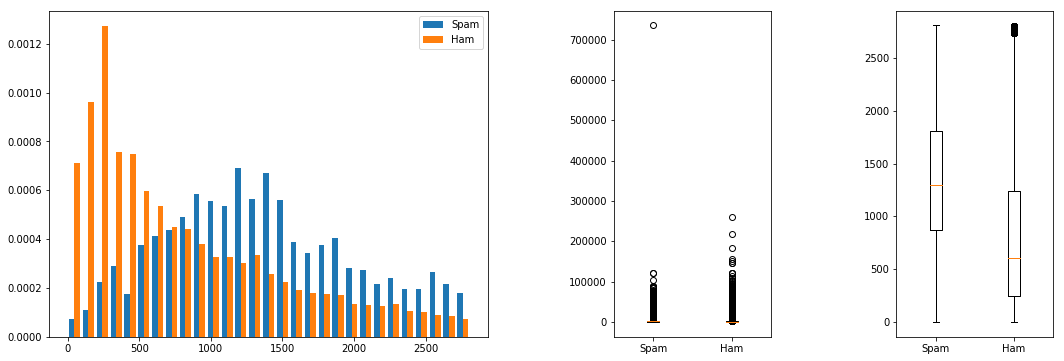

In [26]:
createPlotLenghtDist('textLen', dfMaster) 

## -- Compare clean email message lenght for ham and spam  

In [27]:
#Apply cleaning method
dfMaster['treatedMessage'] = dfMaster['messageStr'].apply(emailTextCleanner)

#Remove stop words
stop = txt.ENGLISH_STOP_WORDS
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stop = stopwords.words('english')
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

dfMaster['treatedTextLen'] = dfMaster['treatedMessage'].apply(lambda x : len(x)) 

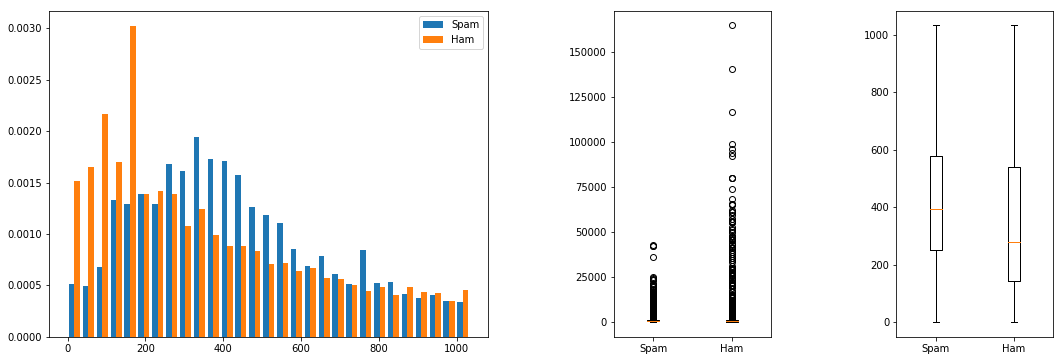

In [28]:
createPlotLenghtDist('treatedTextLen', dfMaster)

## -- Compare total words in a email message for ham and spam  

In [29]:
#Create a column with list of words
dfMaster['wordsList'] = dfMaster['treatedMessage'].str.split().apply(lemmatizeList).apply(revomeWordsWithOneCharacter)

#Create a columns to calculate the total amount of words
dfMaster['totalTreatedWords'] = dfMaster['wordsList'].apply(lambda x : len(x))

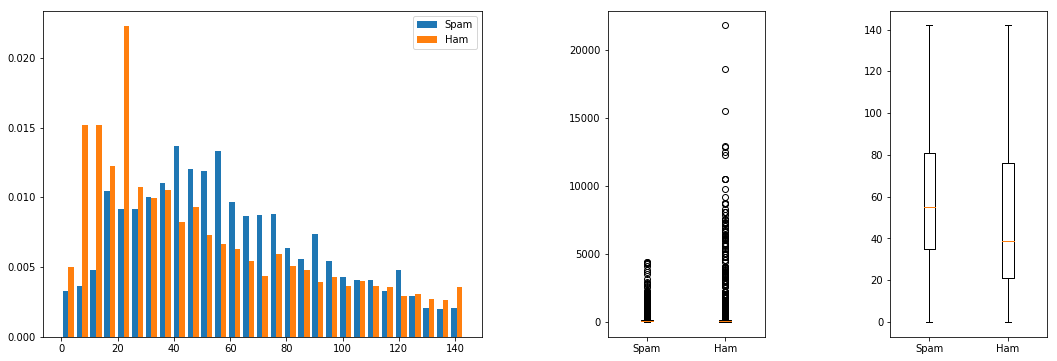

In [30]:
createPlotLenghtDist('totalTreatedWords', dfMaster)

## -- Compare total unique words in a email message for ham and spam  

In [31]:
dfMaster['uniqueWordsLen'] = dfMaster['wordsList'].apply(lambda x : len(set(x)))

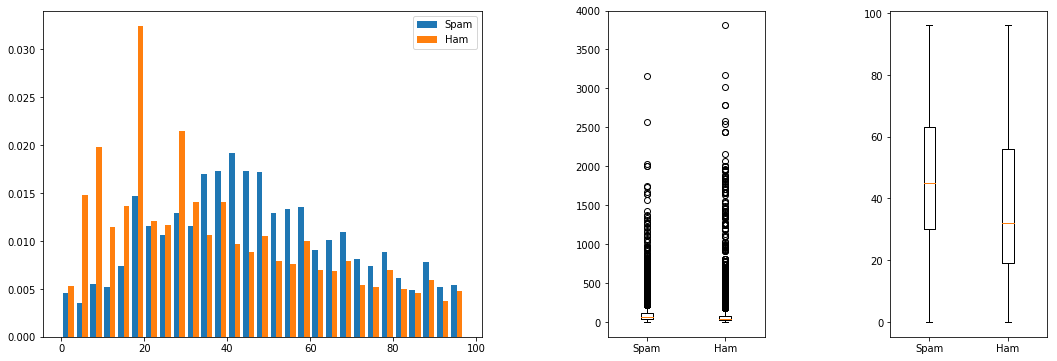

In [32]:
createPlotLenghtDist('uniqueWordsLen', dfMaster)

## Email message Words Visualization

## -- Total uniques words

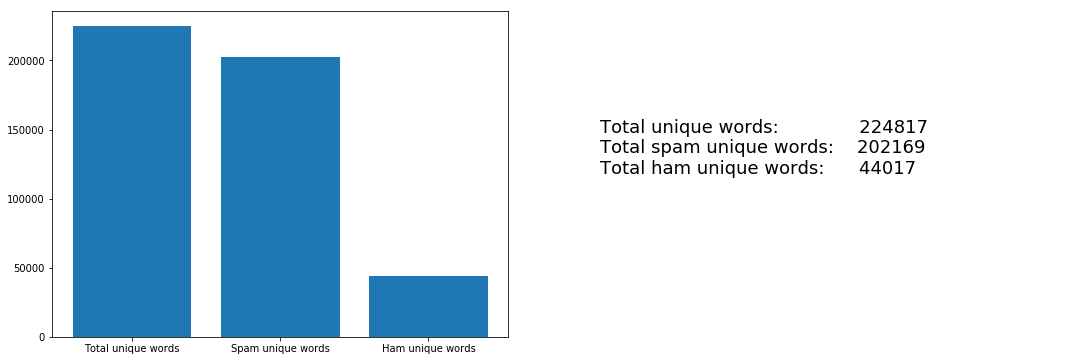

In [33]:
count = Counter(list(chain(*dfMaster["wordsList"].values)))

countSpam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == True]["wordsList"].values)))

countHam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == False]["wordsList"].values)))

totalUniqueWordsPlot(len(count), len(countSpam), len(countHam))

## -- Total Unique words with more the 100 repetitions

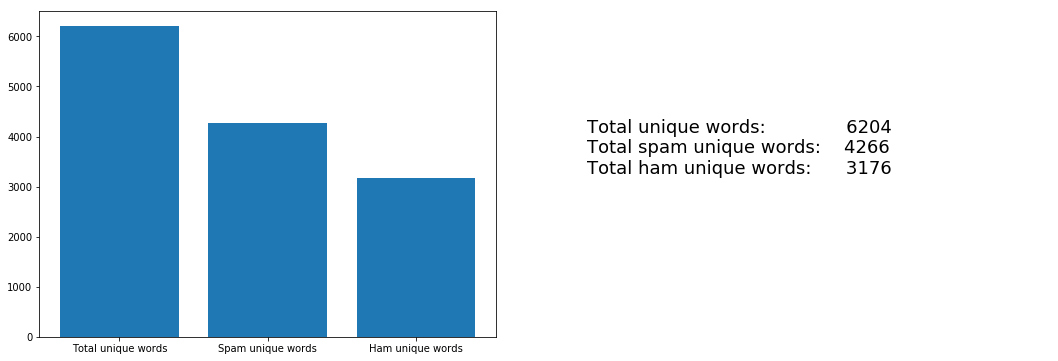

In [34]:
dfCounter = pd.DataFrame.from_dict(data = dict(count),orient='index', columns = ['freq'])

dfCounterSpam = pd.DataFrame.from_dict(data = dict(countSpam),orient='index', columns = ['freq'])

dfCounterHam = pd.DataFrame.from_dict(data = dict(countHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfCounter[dfCounter['freq'] > 100]),
    len(dfCounterSpam[dfCounterSpam['freq'] > 100]),
    len(dfCounterHam[dfCounterHam['freq'] > 100]))


## -- 20 Most common words

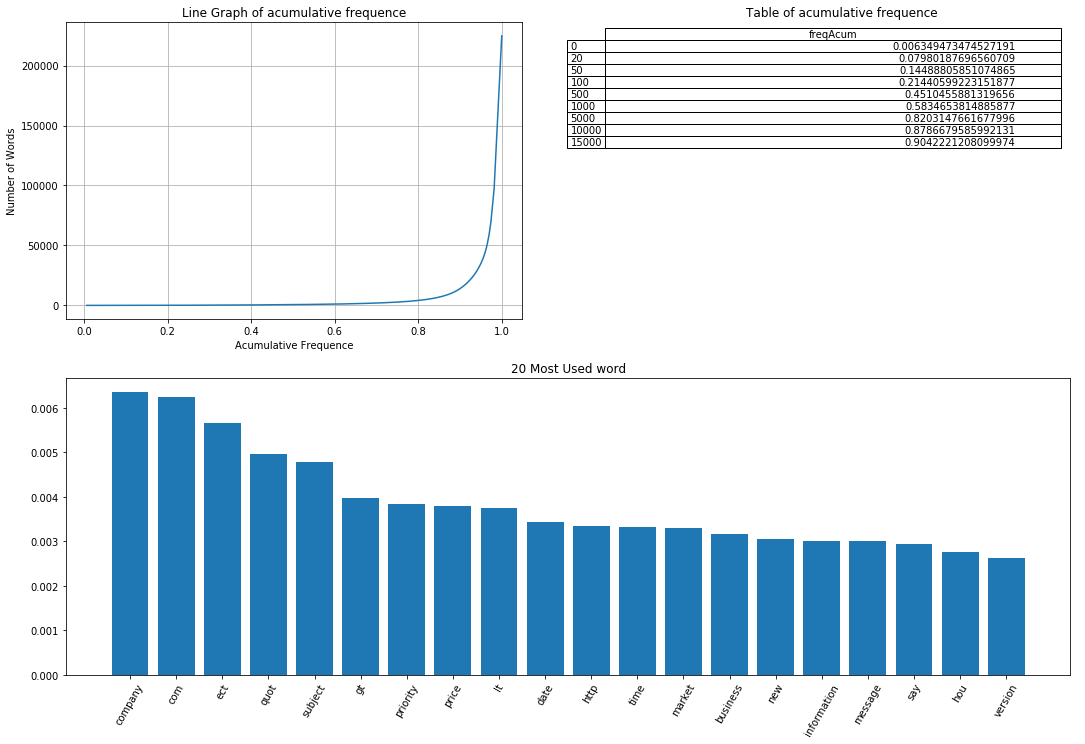

In [35]:
plot20MostWord(count)

## -- 20 Most common words on Spam emails

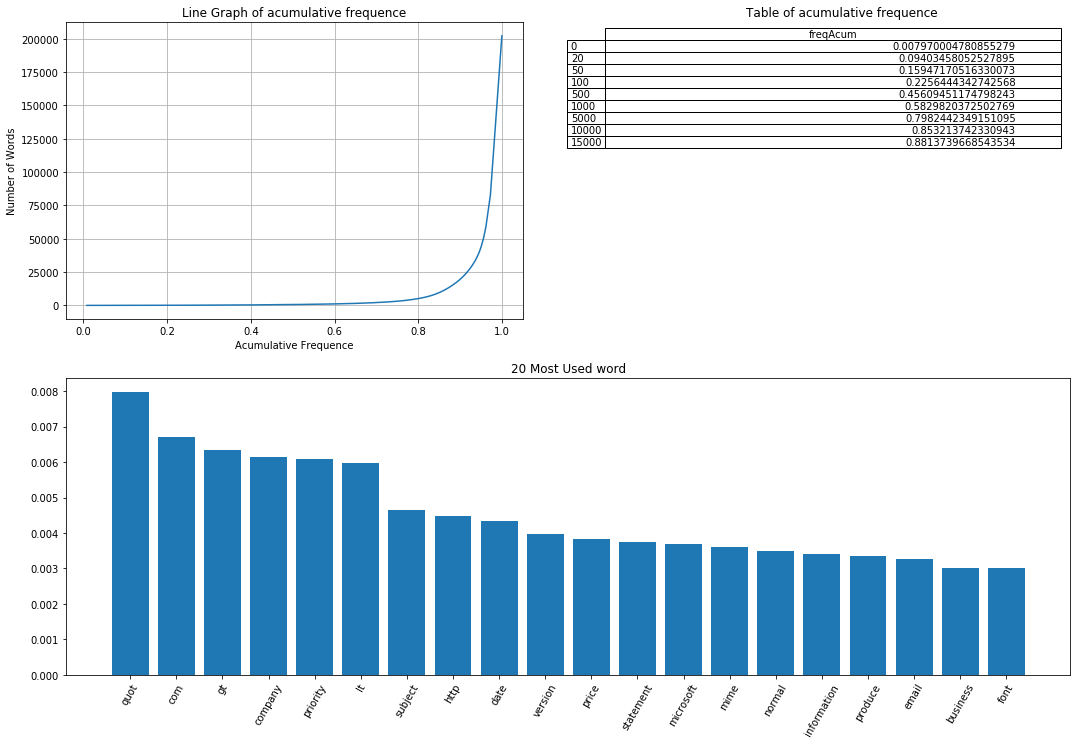

In [36]:
plot20MostWord(countSpam) 

## -- 20 Most common words on Ham emails

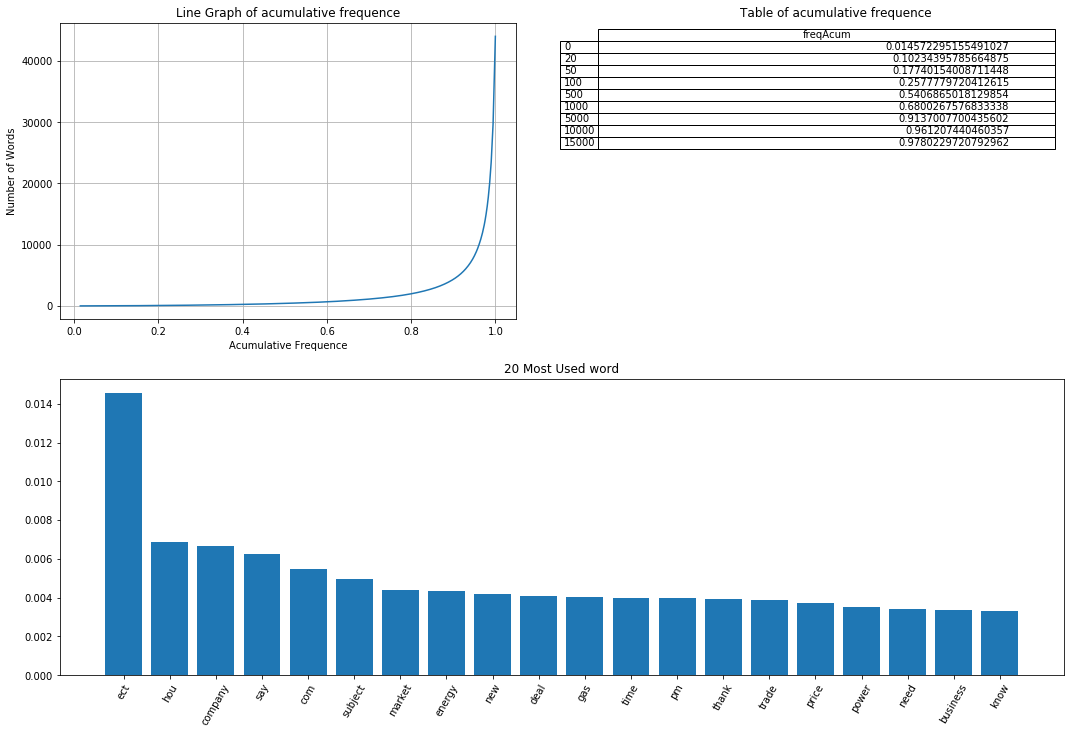

In [37]:
plot20MostWord(countHam)

## Calculate word frequence for subject

## -- Compare email subject lenght for ham and spam

In [38]:
dfMaster['subLen'] = dfMaster['subject'].apply(lambda x : len(str(x)))

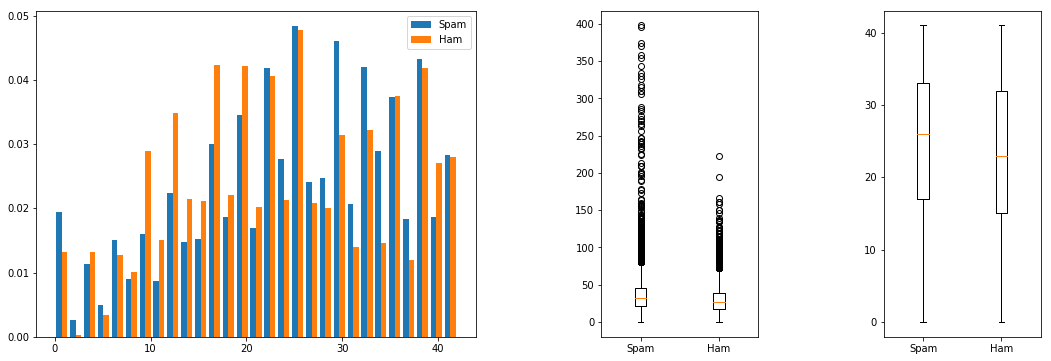

In [39]:
createPlotLenghtDist('subLen', dfMaster)

## -- Compare clean email subject lenght for ham and spam  

In [40]:
#Apply cleaning method
dfMaster['treatedSub'] = dfMaster['subject'].apply(emailTextCleanner)

#Remove stop words
stop = txt.ENGLISH_STOP_WORDS
dfMaster['treatedSub'] = dfMaster['treatedSub'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stop = stopwords.words('english')
dfMaster['treatedSub'] = dfMaster['treatedSub'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

dfMaster['treatedSubLen'] = dfMaster['treatedSub'].apply(lambda x : len(x))

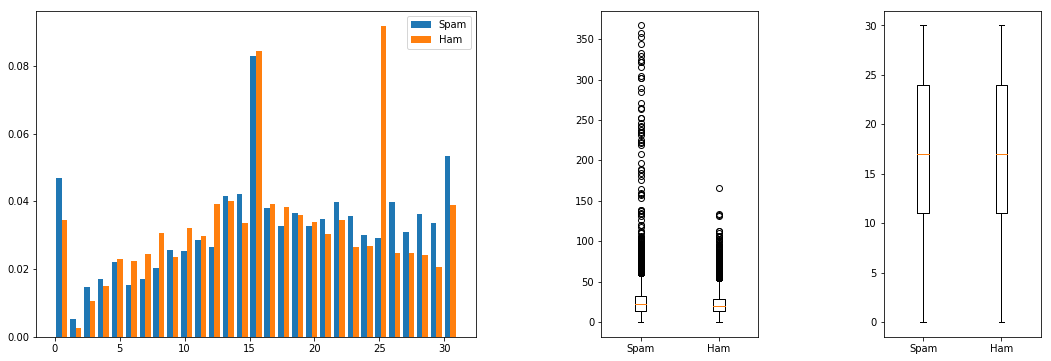

In [41]:
createPlotLenghtDist('treatedSubLen', dfMaster)

## -- Compare total words in a email subject for ham and spam  

In [42]:
#Create a column with list of words
dfMaster['subWordsList'] = dfMaster['treatedSub'].str.split().apply(lemmatizeList).apply(revomeWordsWithOneCharacter)

#Create a columns to calculate the total amount of words
dfMaster['totalTreatedSubWords'] = dfMaster['subWordsList'].apply(lambda x : len(x))

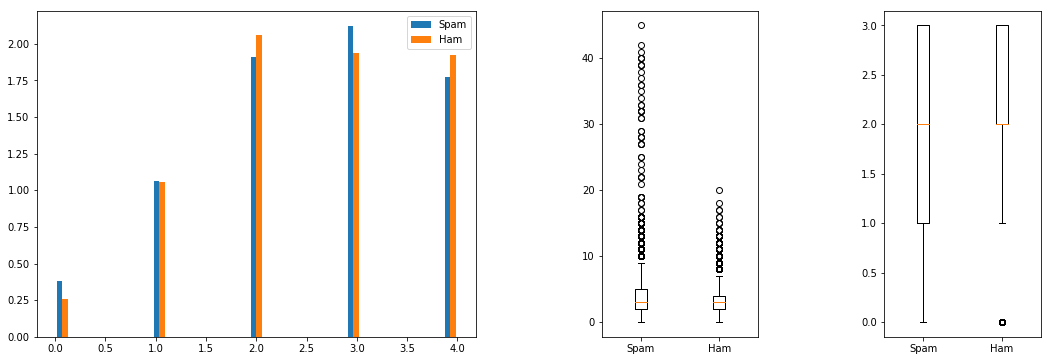

In [43]:
createPlotLenghtDist('totalTreatedSubWords', dfMaster)

## -- Compare total unique words in a email subject for ham and spam  

In [44]:
dfMaster['uniqueSubWordsLen'] = dfMaster['subWordsList'].apply(lambda x : len(set(x)))

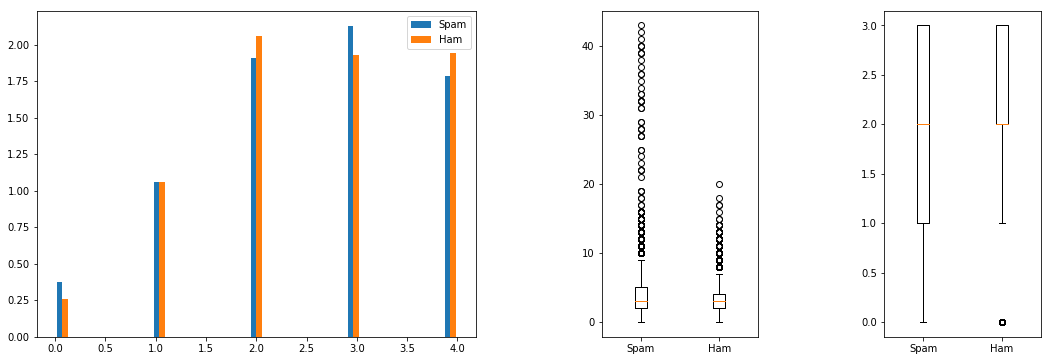

In [45]:
createPlotLenghtDist('uniqueSubWordsLen', dfMaster)

## Email Subject Words Visualization

## -- Total uniques words

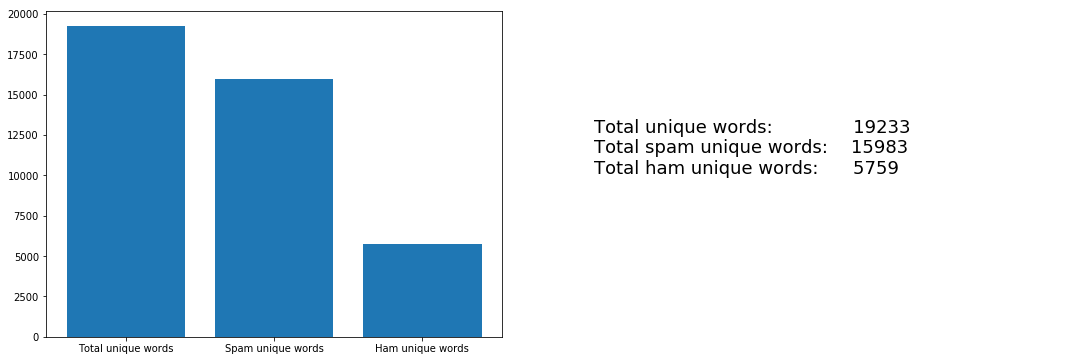

In [46]:
subCount = Counter(list(chain(*dfMaster["subWordsList"].values)))

subCountSpam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == True]["subWordsList"].values)))

subCountHam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == False]["subWordsList"].values)))

totalUniqueWordsPlot(len(subCount), len(subCountSpam), len(subCountHam))

## -- Total Unique words with more the 100 repetitions

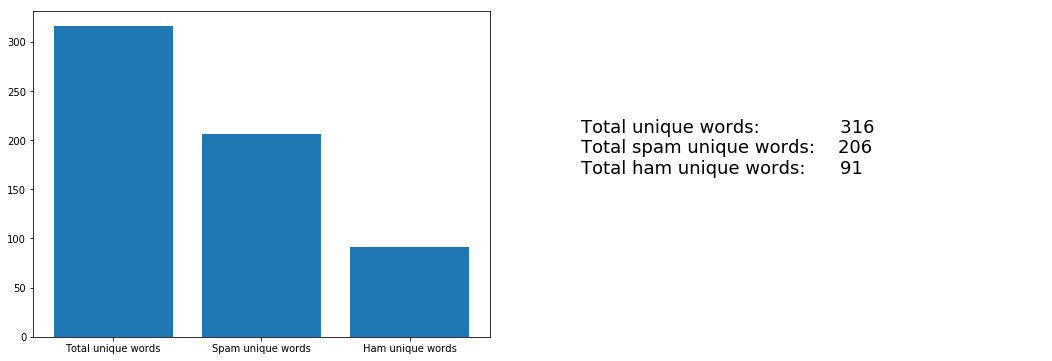

In [47]:
dfSubCounter = pd.DataFrame.from_dict(data = dict(subCount),orient='index', columns = ['freq'])

dfSubCounterSpam = pd.DataFrame.from_dict(data = dict(subCountSpam),orient='index', columns = ['freq'])

dfSubCounterHam = pd.DataFrame.from_dict(data = dict(subCountHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfSubCounter[dfSubCounter['freq'] > 100]),
    len(dfSubCounterSpam[dfSubCounterSpam['freq'] > 100]),
    len(dfSubCounterHam[dfSubCounterHam['freq'] > 100]))

## -- 20 Most common words

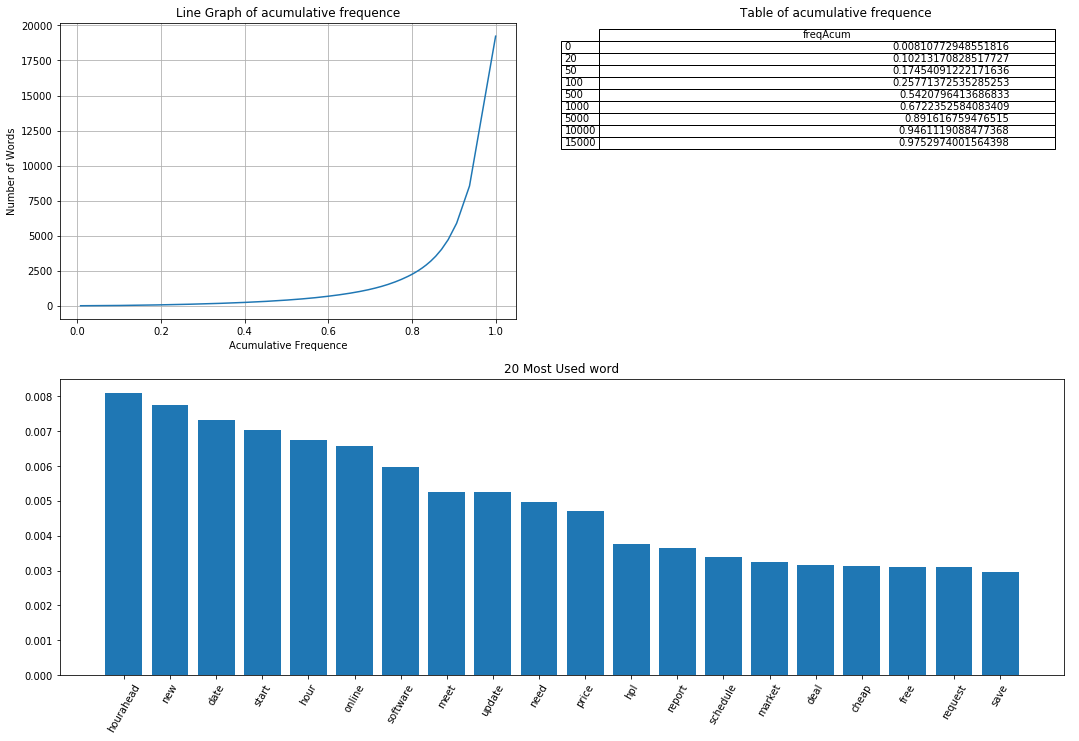

In [48]:
plot20MostWord(subCount)

## -- 20 Most common words on Spam subject emails

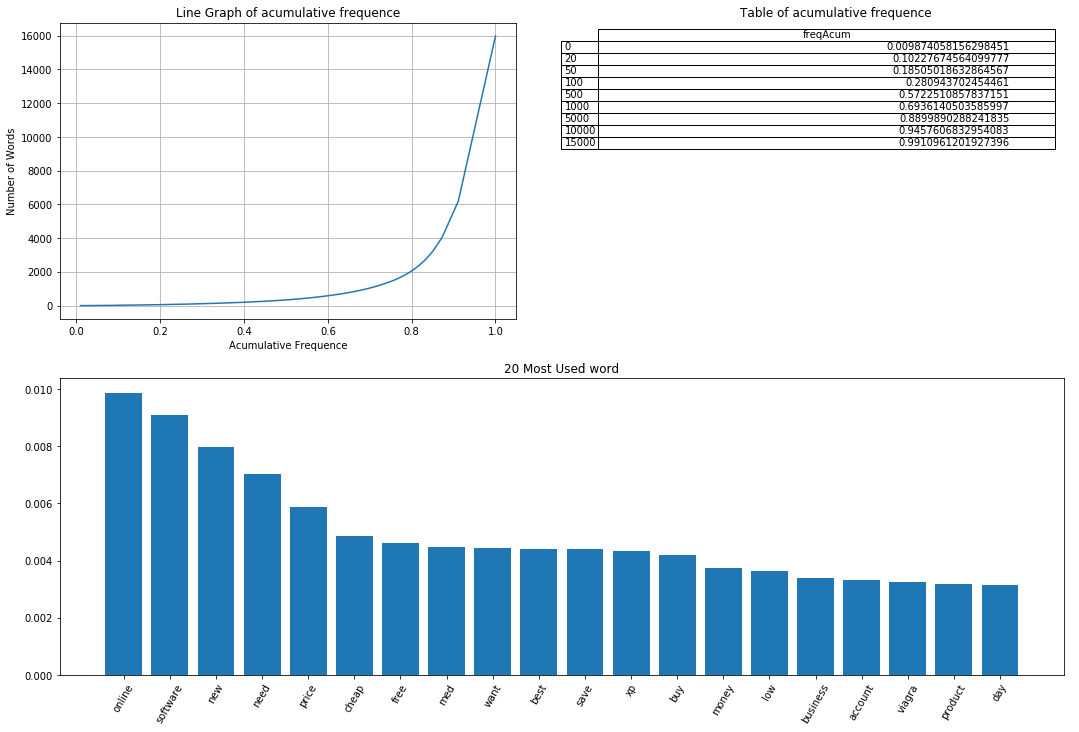

In [49]:
plot20MostWord(subCountSpam)

## -- 20 Most common words on Ham subject emails

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


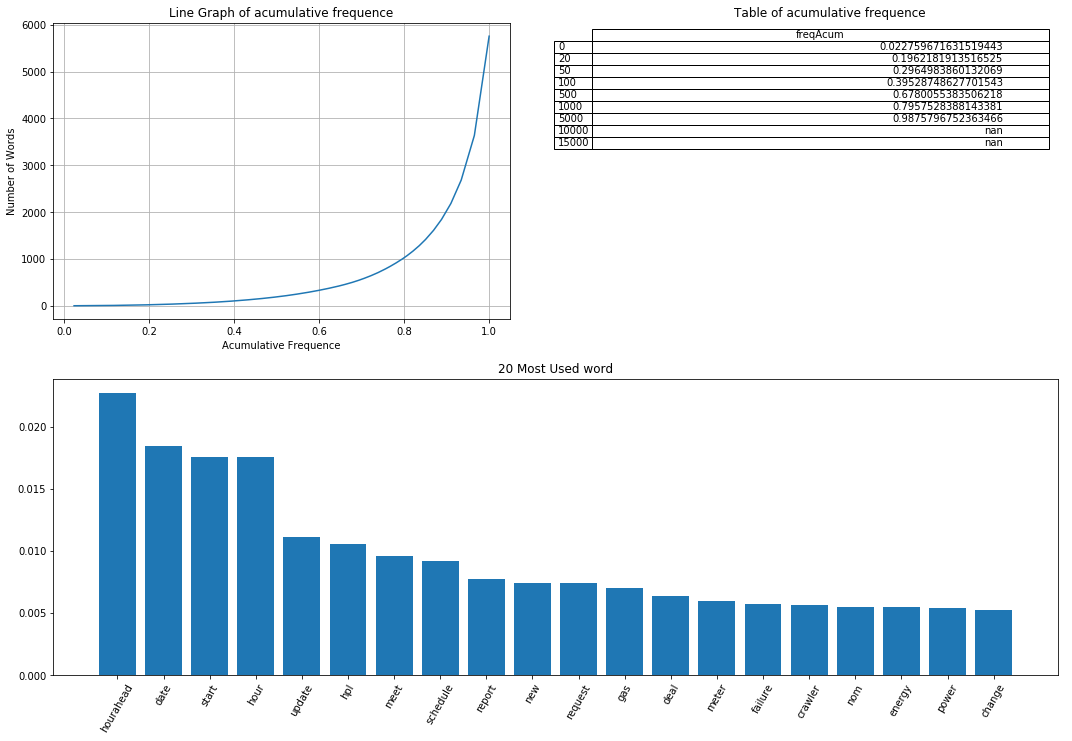

In [50]:
plot20MostWord(subCountHam)

## Forward email distribution by spam and ham

In [51]:
dfMaster['containFW'] = dfMaster['subject'].apply(lambda x : True if "FW:" in str(x) else False)

False    47517
True      1411
Name: containFW, dtype: int64


([<matplotlib.patches.Wedge at 0x7fcdd25c7b38>,
 [Text(-1.195078556186357, 0.10856907728967854, 'False'),
  Text(1.1950785619041513, -0.10856901435080599, 'True')],
 [Text(-0.4979493984109821, 0.04523711553736606, '97%'),
  Text(0.4979494007933964, -0.04523708931283583, '3%')])

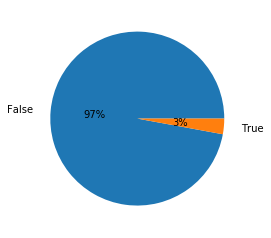

In [52]:
print(dfMaster['containFW'].value_counts())

plt.pie(dfMaster['containFW'].value_counts(), labels=dfMaster['containFW'].unique(), autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)

In [53]:
dfGroupTo = dfMaster.groupby(['containFW', 'isSpam']).size()
print(dfGroupTo.unstack().columns.values)
dfGT = dfGroupTo.unstack()
dfGT['rateF'] = dfGT[False] / (dfGT[False] + dfGT[True])
dfGT['rateT'] = dfGT[True] / (dfGT[False] + dfGT[True])

dfGT.columns = ['Not Spam', 'Spam', 'Rate Not Spam', 'Rate Spam']

dfGT.head()



[False True]


,Not Spam,Spam,Rate Not Spam,Rate Spam
containFW,,,,
False,17765,29752,0.373866,0.626134
True,1314,97,0.931254,0.068746


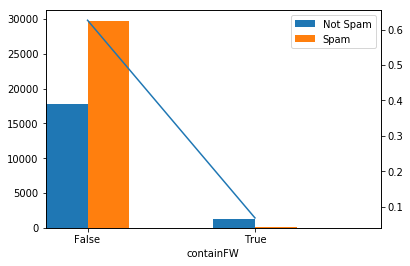

In [54]:
width = .25

dfGT[['Not Spam', 'Spam']].plot(kind='bar')
dfGT['Rate Spam'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-width, len(dfGT)-width])
ax.set_xticklabels(dfGT.index.values)
ax.set_xlabel('Groups')
plt.show()

## Response email distribution by spam and ham

In [55]:
dfMaster['containRE'] = dfMaster['subject'].apply(lambda x : True if "RE:" in str(x) else False)

False    47361
True      1567
Name: containRE, dtype: int64


([<matplotlib.patches.Wedge at 0x7fcdd7811ac8>,
 [Text(-1.1939311335988065, 0.12053401272449489, 'False'),
  Text(1.1939311350094575, -0.12053399875150764, 'True')],
 [Text(-0.4974713056661694, 0.050222505301872875, '97%'),
  Text(0.49747130625394065, -0.05022249947979485, '3%')])

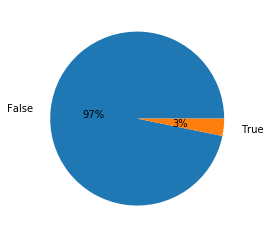

In [56]:
print(dfMaster['containRE'].value_counts())

plt.pie(dfMaster['containRE'].value_counts(), labels=dfMaster['containRE'].unique(), autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)

In [57]:
dfGroupTo = dfMaster.groupby(['containRE', 'isSpam']).size()
print(dfGroupTo.unstack().columns.values)
dfGT = dfGroupTo.unstack()
dfGT['rateF'] = dfGT[False] / (dfGT[False] + dfGT[True])
dfGT['rateT'] = dfGT[True] / (dfGT[False] + dfGT[True])

dfGT.columns = ['Not Spam', 'Spam', 'Rate Not Spam', 'Rate Spam']

dfGT.head()

[False True]


,Not Spam,Spam,Rate Not Spam,Rate Spam
containRE,,,,
False,17781,29580,0.375435,0.624565
True,1298,269,0.828334,0.171666


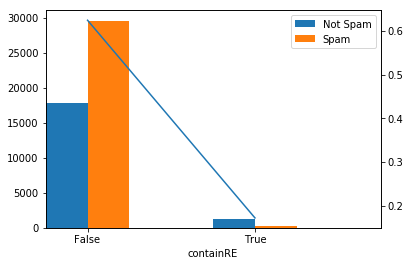

In [58]:
width = .25

dfGT[['Not Spam', 'Spam']].plot(kind='bar')
dfGT['Rate Spam'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-width, len(dfGT)-width])
ax.set_xticklabels(dfGT.index.values)
ax.set_xlabel('Groups')
plt.show()

## Origin Email Server Visualization

In [59]:
dfMaster["orgEmailRoot"] = dfMaster["from"].apply(getEmailRoot)

In [60]:
dfMaster["orgEmailServer"] = dfMaster["orgEmailRoot"].apply(lambda x : getEmailPartRoot(x,1))

## -- Total Unique words

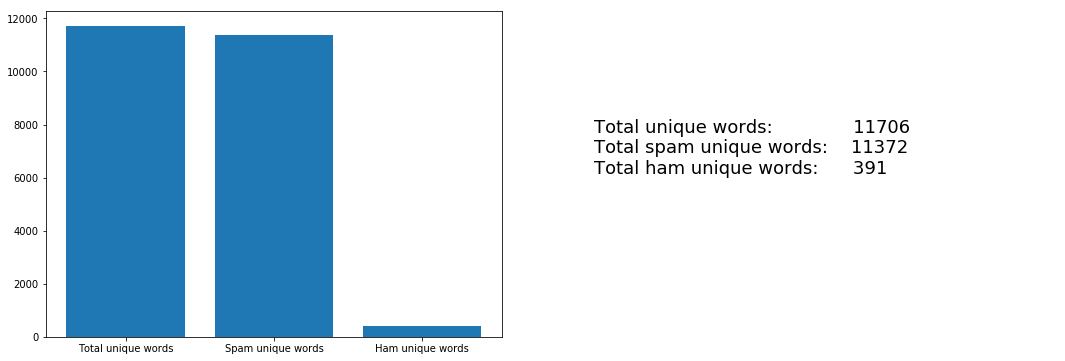

In [61]:
emailServerCount = Counter(list(dfMaster["orgEmailServer"].values))

emailServerCountSpam = Counter(list(dfMaster[dfMaster['isSpam'] == True]["orgEmailServer"].values))

emailServerCountHam = Counter(list(dfMaster[dfMaster['isSpam'] == False]["orgEmailServer"].values))

totalUniqueWordsPlot(len(emailServerCount), len(emailServerCountSpam), len(emailServerCountHam))

## -- Total Unique words with more the 100 repetitions

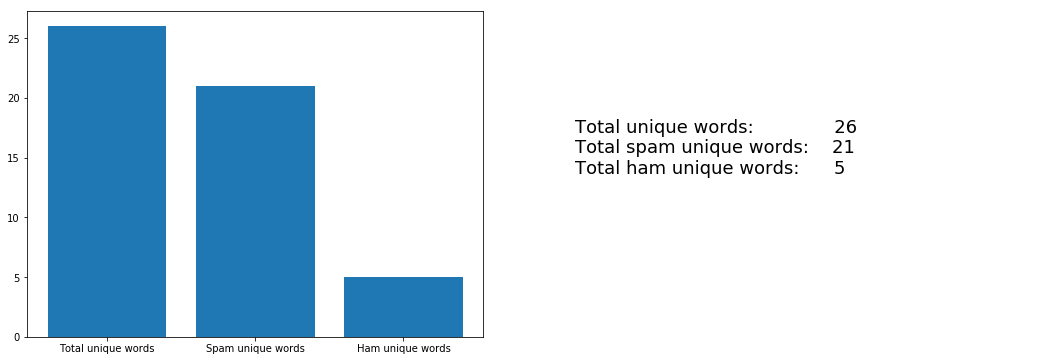

In [62]:
dfEmailServerCounter = pd.DataFrame.from_dict(data = dict(emailServerCount),orient='index', columns = ['freq'])

dfEmailServerCounterSpam = pd.DataFrame.from_dict(data = dict(emailServerCountSpam),orient='index', columns = ['freq'])

dfEmailServerCounterHam = pd.DataFrame.from_dict(data = dict(emailServerCountHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfEmailServerCounter[dfEmailServerCounter['freq'] > 100]),
    len(dfEmailServerCounterSpam[dfEmailServerCounterSpam['freq'] > 100]),
    len(dfEmailServerCounterHam[dfEmailServerCounterHam['freq'] > 100]))

## -- 20 Most common words

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


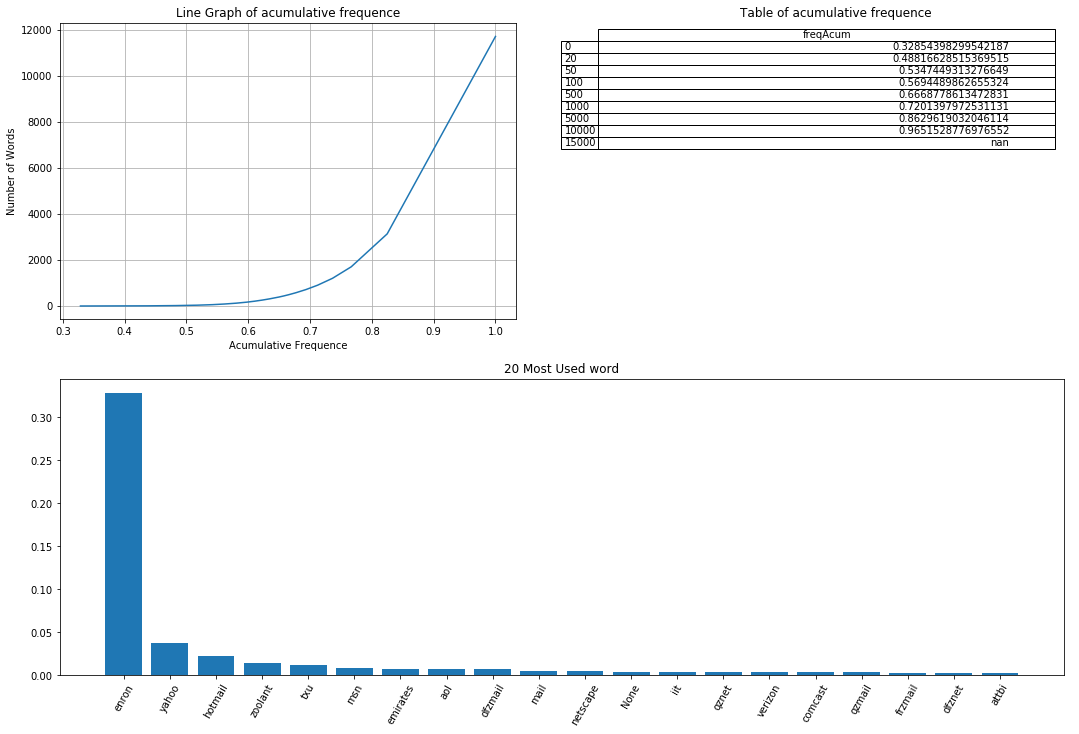

In [63]:
plot20MostWord(emailServerCount) 

## -- 20 Most common words on Spam emails

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


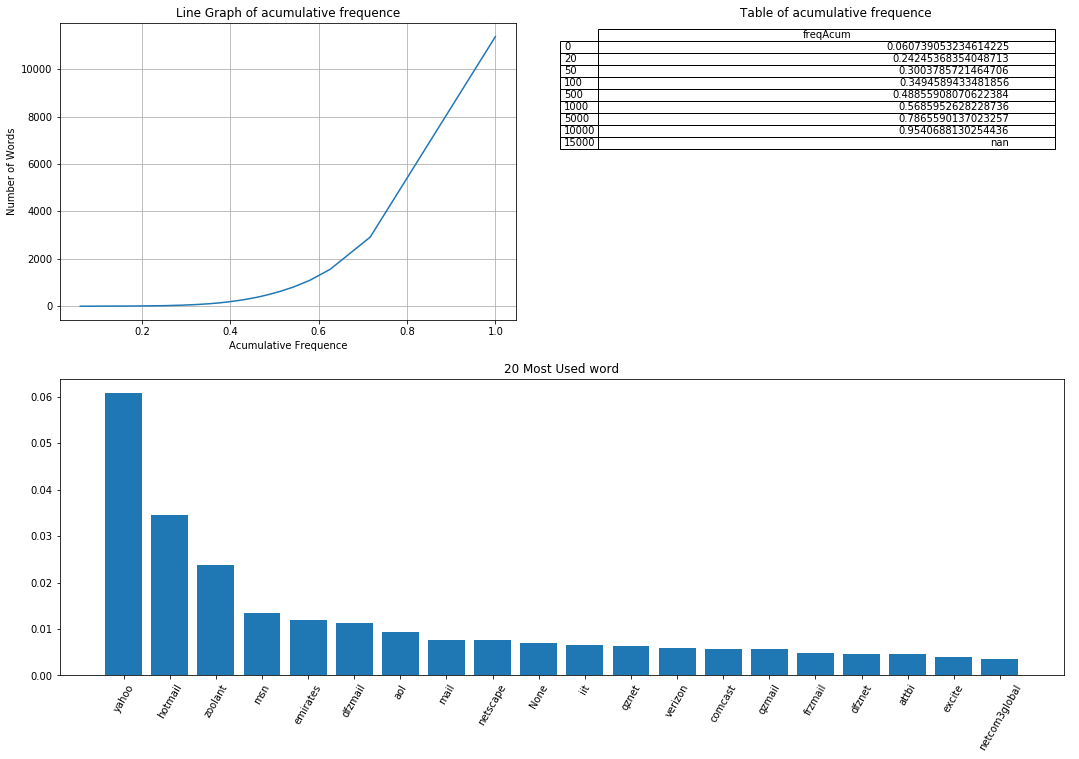

In [64]:
plot20MostWord(emailServerCountSpam) 

## -- 20 Most common words on Ham emails

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


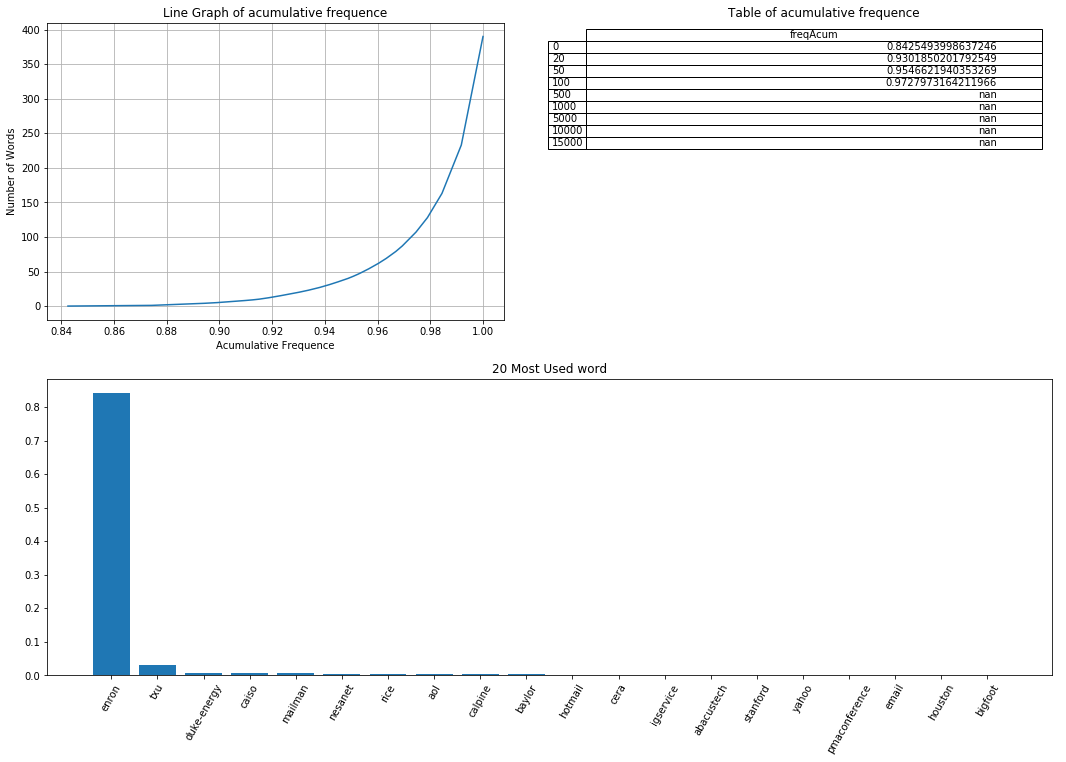

In [65]:
plot20MostWord(emailServerCountHam) 

## Origin Email Name Visualization

In [66]:
dfMaster["orgEmailName"] = dfMaster["orgEmailRoot"].apply(lambda x : getEmailPartRoot(x,0))

## -- Total Unique words

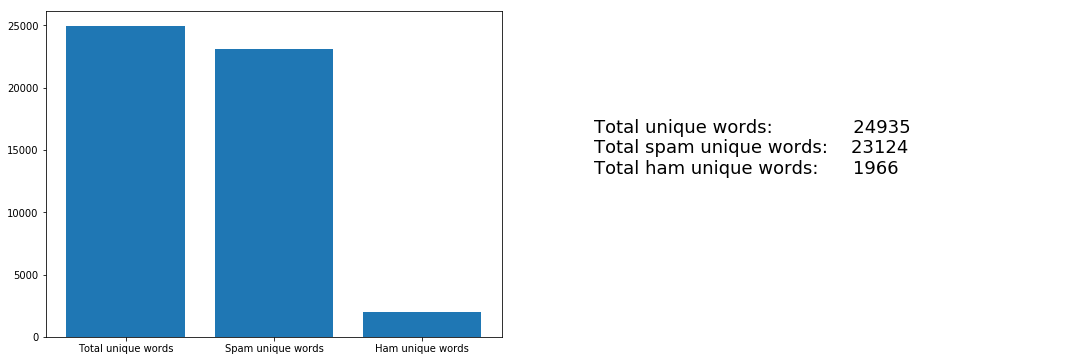

In [67]:
emailNameCount = Counter(list(dfMaster["orgEmailName"].values))

emailNameCountSpam = Counter(list(dfMaster[dfMaster['isSpam'] == True]["orgEmailName"].values))

emailNameCountHam = Counter(list(dfMaster[dfMaster['isSpam'] == False]["orgEmailName"].values))

totalUniqueWordsPlot(len(emailNameCount), len(emailNameCountSpam), len(emailNameCountHam))

## -- Total Unique words with more the 100 repetitions

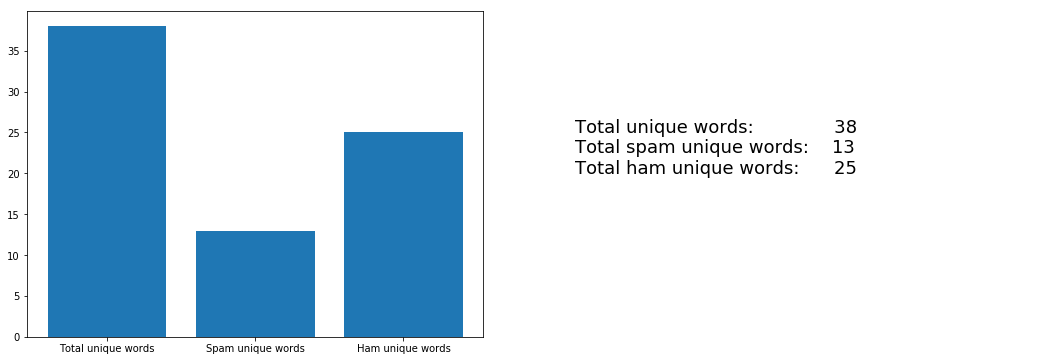

In [68]:
dfEmailNameCounter = pd.DataFrame.from_dict(data = dict(emailNameCount),orient='index', columns = ['freq'])

dfEmailNameCounterSpam = pd.DataFrame.from_dict(data = dict(emailNameCountSpam),orient='index', columns = ['freq'])

dfEmailNameCounterHam = pd.DataFrame.from_dict(data = dict(emailNameCountHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfEmailNameCounter[dfEmailNameCounter['freq'] > 100]),
    len(dfEmailNameCounterSpam[dfEmailNameCounterSpam['freq'] > 100]),
    len(dfEmailNameCounterHam[dfEmailNameCounterHam['freq'] > 100]))


## -- 20 Most common words

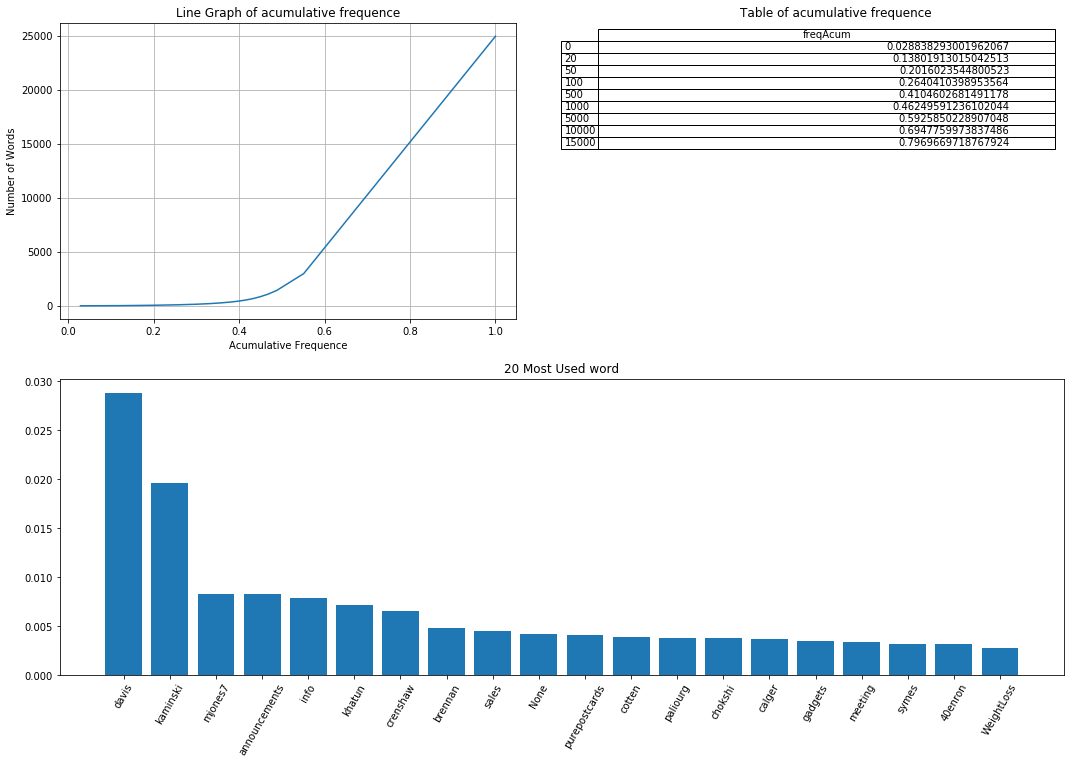

In [69]:
plot20MostWord(emailNameCount) 

## -- 20 Most common words on Spam emails

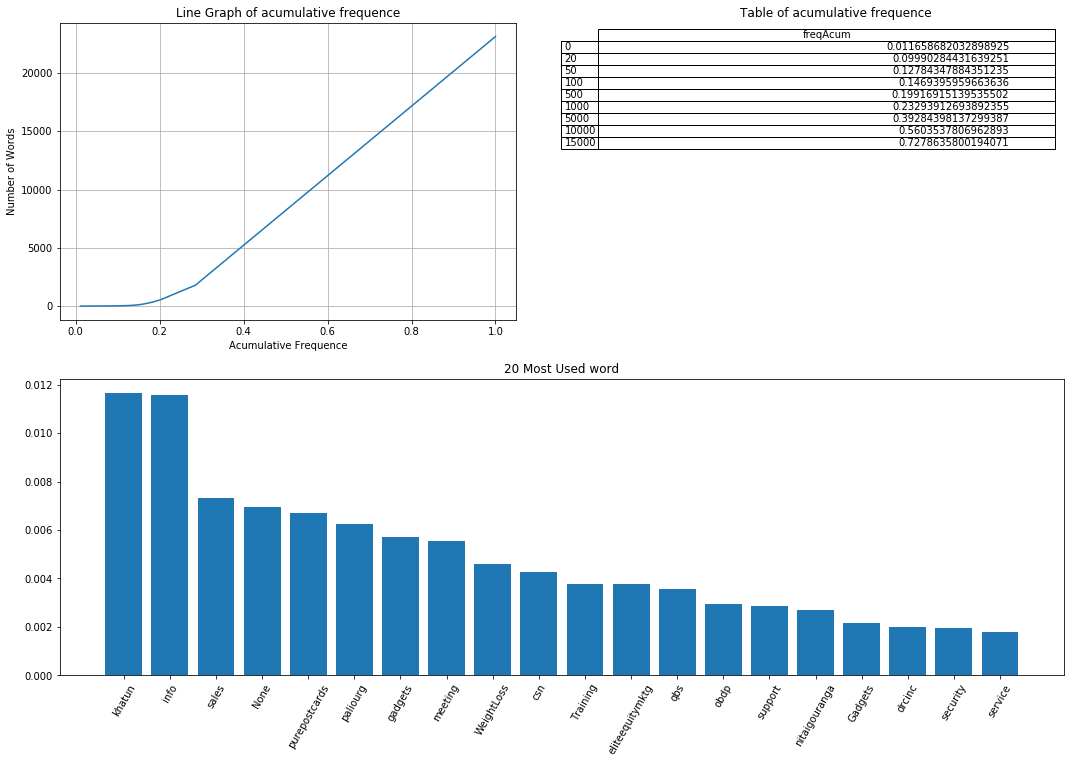

In [70]:
plot20MostWord(emailNameCountSpam)

## -- 20 Most common words on Ham emails

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


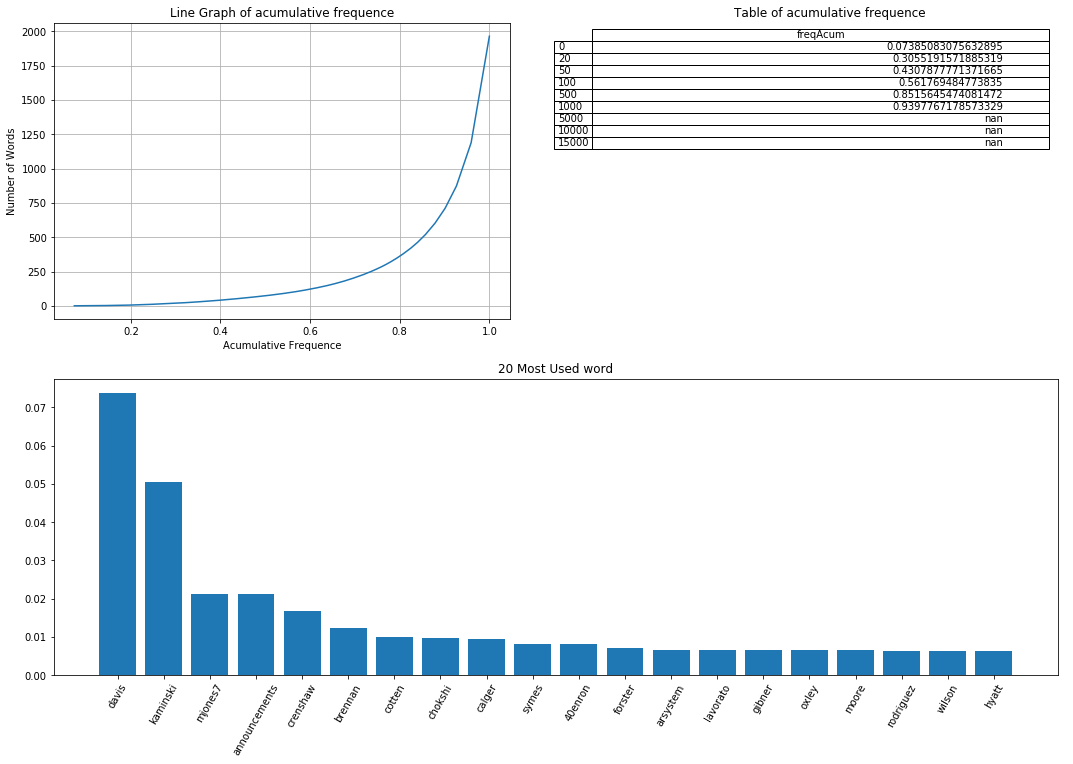

In [71]:
plot20MostWord(emailNameCountHam) 

# Modeling

## -- Create a modeling dataset

In [72]:
dfModeling = dfMaster.loc[:,["isSpam", "hour", "isPlain","toCountGroup", "containFW", "containRE", "orgEmailServer", "orgEmailName", "uniqueSubWordsLen", "uniqueWordsLen",  'subLen', "textLen", 'treatedSub','treatedMessage' ]]


In [73]:
dfModeling.head()

,isSpam,hour,isPlain,toCountGroup,containFW,containRE,orgEmailServer,orgEmailName,uniqueSubWordsLen,uniqueWordsLen,subLen,textLen,treatedSub,treatedMessage
0,True,23.0,True,Direct,False,False,rogers,ezcnppih,3,97,23,1605,squirts like fountain,girlfriend really enjoying making homemade ero...
1,True,6.0,False,Direct,False,False,zoolant,meeting,3,65,39,4171,generation online meetings,gotomeeting generation online meetings arrived...
3,True,9.0,False,Direct,False,False,yahoo,KHTIQA,5,66,67,1582,new challenges ref wed jul,hq management bank account open new need excel...
4,True,21.0,False,Direct,False,False,nteu35,assisneto2003,5,60,43,1338,save money buy getting thing,projecthoneypotmailserver smtp jul squirrelmai...
5,True,5.0,False,Direct,False,False,Barclays,account,3,0,32,2,important notice june,


## -- Check for null values and remove it

In [74]:
print("Total dataset size: {}".format(len(dfModeling)))
print("Total dataset size withou null values: {}".format(len(dfModeling.dropna())))
dfModeling = dfModeling.dropna() 

Total dataset size: 48928
Total dataset size withou null values: 48633


## -- Split modeling dataset

In [ ]:
#train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainD
x_train, x_test, y_train, y_test = train_test_split(dfModeling[["hour", "isPlain","toCountGroup", "containFW", "containRE", "orgEmailServer", "orgEmailName", "uniqueSubWordsLen", "uniqueWordsLen",  'subLen', "textLen", 'treatedSub','treatedMessage']],dfModeling['isSpam'])

## -- Convert message to feature

## ---  Count Vectors as features

In [ ]:
count_vect = CountVectorizer(analyzer='word', min_df= 100, token_pattern=r'\w{1,}')
count_vect.fit(x_train['treatedMessage'])
xtrain_count =  count_vect.transform(x_train['treatedMessage'])
xtest_count =  count_vect.transform(x_test['treatedMessage'])


## --- TF-IDF

In [ ]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=6200)
tfidf_vect.fit(dfModeling['treatedMessage'])
xtrain_tfidf =  tfidf_vect.transform(x_train['treatedMessage'])
xtest_tfidf =  tfidf_vect.transform(x_test['treatedMessage'])

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=6200)
tfidf_vect_ngram.fit(dfModeling['treatedMessage'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train['treatedMessage'])
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(x_test['treatedMessage'])

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=6200)
tfidf_vect_ngram_chars.fit(dfModeling['treatedMessage'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train['treatedMessage']) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test['treatedMessage']) 

## -- Create Models based in only email message feature

## --- Naive Bayes

In [ ]:
# Naive Bayes on Count Vectors
countVectAccuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count, y_test)
print ("Count Vectors: {}".format(countVectAccuracy))

# Naive Bayes on Word Level TF IDF Vectors
tfWLAccuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf, y_test)
print ("WordLevel TF-IDF:  {}".format(tfWLAccuracy))

# Naive Bayes on Ngram Level TF IDF Vectors
tfNGAccuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print ("N-Gram Vectors:  {}".format(tfNGAccuracy))

# Naive Bayes on Character Level TF IDF Vectors
tfCLAccuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print ("CharLevel Vectors:  {}".format(tfCLAccuracy))

## --- SVM Model

In [ ]:
svmAccuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("N-Gram Vectors: {}".format(svmAccuracy))

## --- Random Forest (Bagging Model)

In [ ]:
# RF on Count Vectors
rfCountAccuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, y_train, xtest_count, y_test)
print ("Count Vectors: {}".format(rfCountAccuracy))

# RF on Word Level TF IDF Vectors
rfWLAccuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, y_train, xtest_tfidf, y_test)
print ("WordLevel TF-IDF: {}".format(rfWLAccuracy))


## -- Model Comparison

## Correlation

In [ ]:
stop / here

In [ ]:
print(dfMaster.columns)
dfModeling = dfMaster.loc[:,["isSpam", "hour", "toCountGroup", "containFW", "containRE", "uniqueSubWordsLen", 'textLen', 'subLen', 'uniqueWordsLen' ]]

In [ ]:
dfModeling.describe()



In [ ]:
corr = dfModeling.corr()
corr.style.background_gradient(cmap='coolwarm')


In [ ]:
from statsmodels.formula.api import ols

In [ ]:
import statsmodels

formula = 'isSpam ~ C(hour)+ C(toCountGroup)+ C(containFW)+ C(containRE)+ C(uniqueSubWordsLen)+ C(textLen)+ C(subLen)+ C(uniqueWordsLen)'
model = ols(formula, dfModeling).fit()


In [ ]:
model.summary()

In [ ]:
import statsmodels.api as sm

aov_table = sm.stats.anova_lm(model)
print(aov_table)